<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos Reviews

## 1) Introdução
Uma importante abordagem ao trabalhar com análise de dados de uma base comercial é justamente o feedback dos consumidores no que diz respeito à qualidade dos produtos, ao atendimento, etc. e a neste sentido é de suma importância ter uma base de dados que tenham essas informações, uma vez que elas ajudam a melhorar a qualidade do serviço.

Aqui não é diferente e neste notebook trabalharemos com uma base contendo, entre outros, os reviews dos clientes acerca dos produtos e uma nota atribuida a ele. Assim, utilizaremos alguns algorítmos de Processamento de Linguagem Natural (em inglês NPL) para fazer um classificador de sentimento, ou seja, determinar se um determinado review é positivo ou negativo.

Portanto, a partir da próxima seção iremos dar início a esta etapa do estudo.

## 2) Carregando e explorando os dados

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carregando a base de dados
link = 'https://raw.githubusercontent.com/Mario-RJunior/olist-e-commerce/master/datasets/olist_order_reviews_dataset.csv'
reviews = pd.read_csv(link)

In [3]:
# Visualizando o cabeçalho
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
# Verificando o shape do dataframe
reviews.shape

(100000, 7)

In [5]:
# Retornando informações sobre o dataframe
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [6]:
# Retornando algumas estatísticas
reviews.describe()

,review_score
count,100000.000000
mean,4.070890
std,1.359663
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
# Verificando valores faltantes
reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

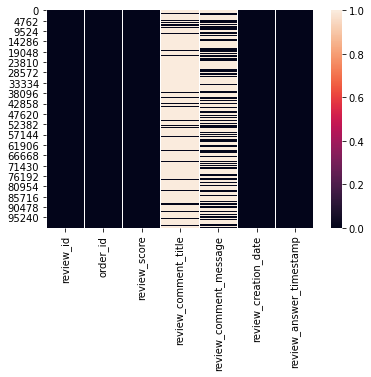

In [8]:
# Visualizando valores faltantes com heatmap
sns.heatmap(data=reviews.isnull());

Confirmamos que há uma grande quantidade de valores faltantes.

In [9]:
# Visualizando alguns comentários
reviews['review_comment_message']

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                    Recebi bem antes do prazo estipulado.
4        Parabéns lojas lannister adorei comprar pela I...
                               ...                        
99995                                                  NaN
99996    Excelente mochila, entrega super rápida. Super...
99997                                                  NaN
99998    Solicitei a compra de uma capa de retrovisor c...
99999    meu produto chegou e ja tenho que devolver, po...
Name: review_comment_message, Length: 100000, dtype: object

In [10]:
# Visualizando alguns títulos dos comentários
reviews['review_comment_title'].unique()

array([nan, 'recomendo', 'Super recomendo', ...,
       'Não foi entregue o pedido', 'OTIMA EMBALAGEM', 'Foto enganosa '],
      dtype=object)

In [11]:
# Número de títulos não únicos
reviews['review_comment_title'].nunique()

4600

In [12]:
# Contagem dos scores
reviews['review_score'].value_counts()

5    57420
4    19200
1    11858
3     8287
2     3235
Name: review_score, dtype: int64

Podemos ainda fazer um histograma para verificar a ocorrência dos scores.

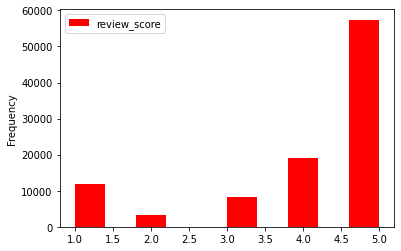

In [13]:
# # Plotando histograma
reviews.plot(kind='hist', color='r');

### Adicionando coluna para classificação

No dataframe reviews temos a coluna "review_score" que representa as notas (de 1 a 5) para os serviços oferecidos. Neste caso, como queremos criar um classificador binário para os comentários (positivos e negativos) devemos então gerar esta classificação baseado no score dado para cada comentário. Assim, tomaremos o seguinte critério:

- scores 1, 2 e 3: comentário negativo = 0;
- scores 4 e 5: comentário positivo = 1.

Desta forma, adicionaremos a coluna "feedback" com a respectiva classificação para cada comentário.

In [14]:
# Adicionando a coluna "feedback"
reviews['feedback'] = reviews['review_score'].apply(lambda x: 1 if x >= 4 else 0)

In [15]:
# Verificando o dataframe com a nova coluna
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,feedback
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1
...,...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,1
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,1
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,1
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43,0


Agora precisamos eliminar as colunas do dataframe que não serão utilizadas. Logo, deixaremos apenas as colunas "review_comment_message" e "feedback".

In [16]:
# Deletando colunas desnecessárias
reviews = reviews.drop(columns=['review_id', 'order_id', 'review_score', 
                                'review_comment_title', 'review_creation_date',	
                                'review_answer_timestamp'], axis=1)

# Visualizando o cabeçalho
reviews.head()

,review_comment_message,feedback
0,NaN,1
1,NaN,1
2,NaN,1
3,Recebi bem antes do prazo estipulado.,1
4,Parabéns lojas lannister adorei comprar pela I...,1


In [17]:
# Deletando registros com valores faltantes
reviews.dropna(inplace=True)

In [18]:
# Visualizando o cabeçalho
reviews.head()

,review_comment_message,feedback
3,Recebi bem antes do prazo estipulado.,1
4,Parabéns lojas lannister adorei comprar pela I...,1
9,aparelho eficiente. no site a marca do aparelh...,1
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,"Vendedor confiável, produto ok e entrega antes...",1


In [19]:
# Visualizando o novo shape do dataframe
reviews.shape

(41753, 2)

Podemos confirmar que o novo dataframe não tem valores faltantes pelo heatmap.

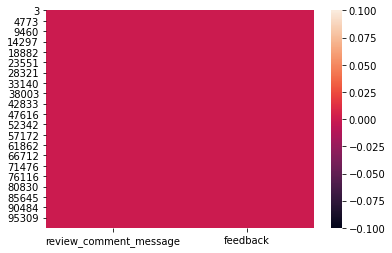

In [20]:
# Heatmap
sns.heatmap(data=reviews.isnull());

In [21]:
reviews.isnull().sum()

review_comment_message    0
feedback                  0
dtype: int64

Podemos plotar um histograma da coluna "feedback".

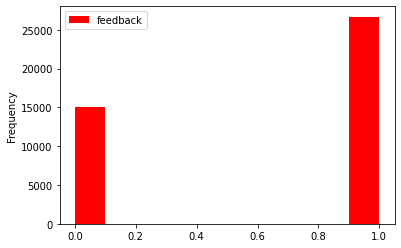

In [22]:
reviews.plot(kind='hist', color='r');

Podemos ainda adicionar mais uma estatística para entendermos melhor os nossos dados. Neste caso, iremos verificar qual é, em média, o número de caracteres de cada comentário. Criaremos então, outro dataframe para este fim.

In [23]:
# Criação do novo dataframe
reviews_character_length = reviews.copy() 

# Criando a coluna com o número de caracteres
reviews_character_length['length'] = reviews['review_comment_message'].apply(len)

In [24]:
# Visualizando o cabeçalho
reviews_character_length

,review_comment_message,feedback,length
3,Recebi bem antes do prazo estipulado.,1,37
4,Parabéns lojas lannister adorei comprar pela I...,1,100
9,aparelho eficiente. no site a marca do aparelh...,1,174
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1,45
15,"Vendedor confiável, produto ok e entrega antes...",1,56
...,...,...,...
99983,Entregou dentro do prazo. O produto chegou em ...,1,91
99990,"O produto não foi enviado com NF, não existe v...",0,125
99996,"Excelente mochila, entrega super rápida. Super...",1,67
99998,Solicitei a compra de uma capa de retrovisor c...,0,198


In [25]:
# Estatísticas de reviews_character_length
reviews_character_length.describe()

,feedback,length
count,41753.000000,41753.000000
mean,0.638996,70.038632
std,0.480297,54.778207
min,0.000000,1.000000
25%,0.000000,28.000000
50%,1.000000,54.000000
75%,1.000000,97.000000
max,1.000000,208.000000


In [26]:
# Checando alguns reviews
reviews_character_length.query('length == 1')

,review_comment_message,feedback,length
299,A,1,1
1603,X,1,1
2398,A,0,1
3845,.,1,1
4373,.,1,1
...,...,...,...
92797,.,1,1
94124,,1,1
94943,.,1,1
95538,S,1,1


In [27]:
# Verificando a quantidade de caracteres únicos
reviews_character_length.query('length == 1')['review_comment_message'].value_counts()

.    51
      9
A     4
?     3
5     3
-     3
S     2
o     2
*     2
😀     2
👍     2
s     2
m     2
I     1
L     1
0     1
t     1
4     1
,     1
👎     1
K     1
X     1
9     1
x     1
B     1
W     1
Y     1
8     1
O     1
Name: review_comment_message, dtype: int64

In [28]:
# Checando alguns reviews
reviews_character_length.query('length == 208.000000')['review_comment_message'].iloc[0]

'NÃO RECEBI O PRODUTO, O PRODUTO CONSTA COMO ENVIADO PARA O CORREIO DE RIBEIRÃO PRETO. O CORREIO NÃO RECEBEU O PRODUTO. ENVIE VARIAS MENSAGEM PARA A targaryen E NÃO OBTIVE. ESTA targaryen ESTA SUJANDO SEU NOME'

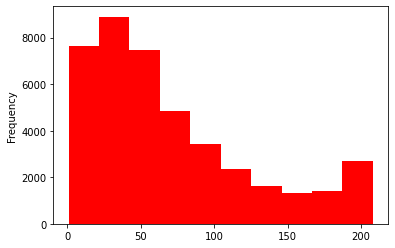

In [29]:
# Histograma para o tamanho dos reviews
reviews_character_length['length'].plot(kind='hist', color='r');

### Reviews positivos e negativos

Iremos agora gerar dataframes com reviews positivos e negativos e comparar ambos.

In [30]:
# Dataframe negativo
negative = reviews_character_length.query('feedback == 0')
negative.head()

,review_comment_message,feedback,length
16,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",0,78
19,Péssimo,0,7
29,Não gostei ! Comprei gato por lebre,0,35
32,Sempre compro pela Internet e a entrega ocorre...,0,173
39,Nada de chegar o meu pedido.,0,28


In [31]:
# Shape
negative.shape

(15073, 3)

In [32]:
# Visualizando estatística
negative.describe()

,feedback,length
count,15073.0,15073.000000
mean,0.0,97.485570
std,0.0,60.328699
min,0.0,1.000000
25%,0.0,46.000000
50%,0.0,86.000000
75%,0.0,148.000000
max,0.0,208.000000


In [33]:
# Dataframe positivo
positive = reviews_character_length.query('feedback == 1')
positive.head()

,review_comment_message,feedback,length
3,Recebi bem antes do prazo estipulado.,1,37
4,Parabéns lojas lannister adorei comprar pela I...,1,100
9,aparelho eficiente. no site a marca do aparelh...,1,174
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1,45
15,"Vendedor confiável, produto ok e entrega antes...",1,56


In [34]:
# Shape
positive.shape

(26680, 3)

In [35]:
# Visualizando estatística
positive.describe()

,feedback,length
count,26680.0,26680.000000
mean,1.0,54.532346
std,0.0,44.426964
min,1.0,1.000000
25%,1.0,22.000000
50%,1.0,43.000000
75%,1.0,72.000000
max,1.0,207.000000


Vemos que os comentários negativos é, em média, maior do que os positivos e um motivo plausível é a possibilidade de as pessoas com queixas do serviço explicarem mais detalhadamente sua insatisfação.

### Nuvem de palavras

Agora, criaremos duas nuvens de palavra para cada dataframe (positivo e negativo) para entendermos quais palavras mais se destacam em ambos os casos. Para isso, devemos colocar todos os reviews como se fosse uma string apenas. Então, temos o seguinte código com este propósito.

- Reviews positivos

In [36]:
# Colocando reviews positivos em uma lista
positive_reviews = positive['review_comment_message'].tolist()

# Visualizando os 5 primeiros reviews
positive_reviews[0:5]

['Recebi bem antes do prazo estipulado.',
 'Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa',
 'aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho',
 'Mas um pouco ,travando...pelo valor ta Boa.\r\n',
 'Vendedor confiável, produto ok e entrega antes do prazo.']

In [37]:
# Juntando em apenas uma string
sentence_as_one_string = ' '.join(positive_reviews)

Gerando a nuvem de palavras.

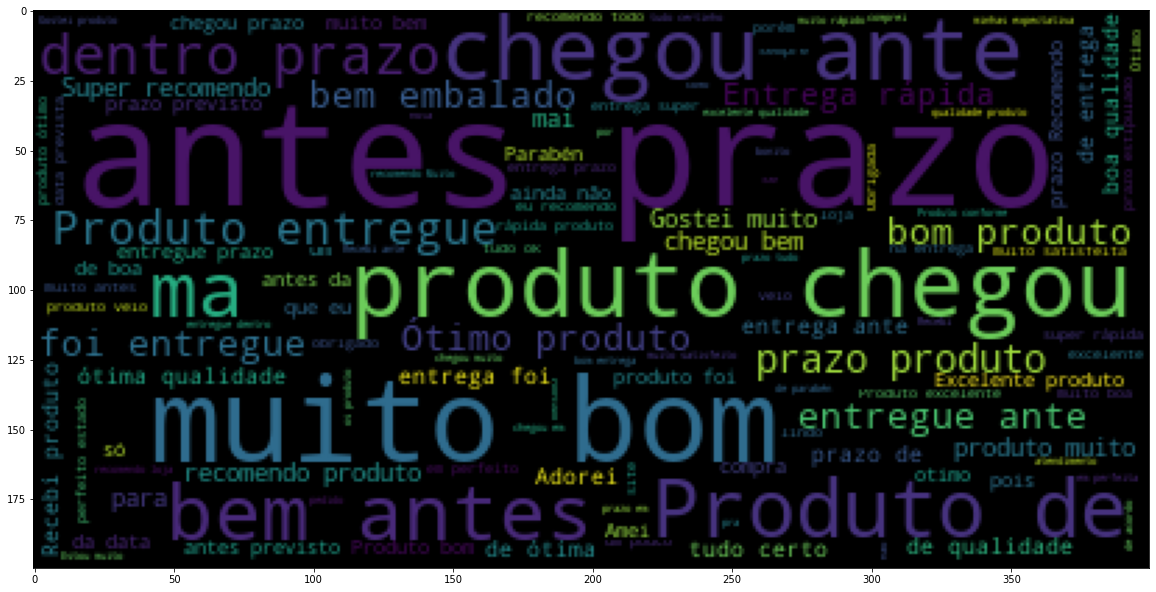

In [38]:
# Importando a biblioteca
from wordcloud import WordCloud

# Gerando a imagem
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentence_as_one_string));

- Reviews negativos

In [39]:
# Colocando reviews negativos em uma lista
negative_reviews = negative['review_comment_message'].tolist()

# Visualizando os 5 primeiros reviews
negative_reviews[0:5]

['GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU',
 'Péssimo',
 'Não gostei ! Comprei gato por lebre',
 'Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.',
 'Nada de chegar o meu pedido.']

In [40]:
# Juntando em apenas uma string
negative_sentence_as_one_string = ' '.join(negative_reviews)

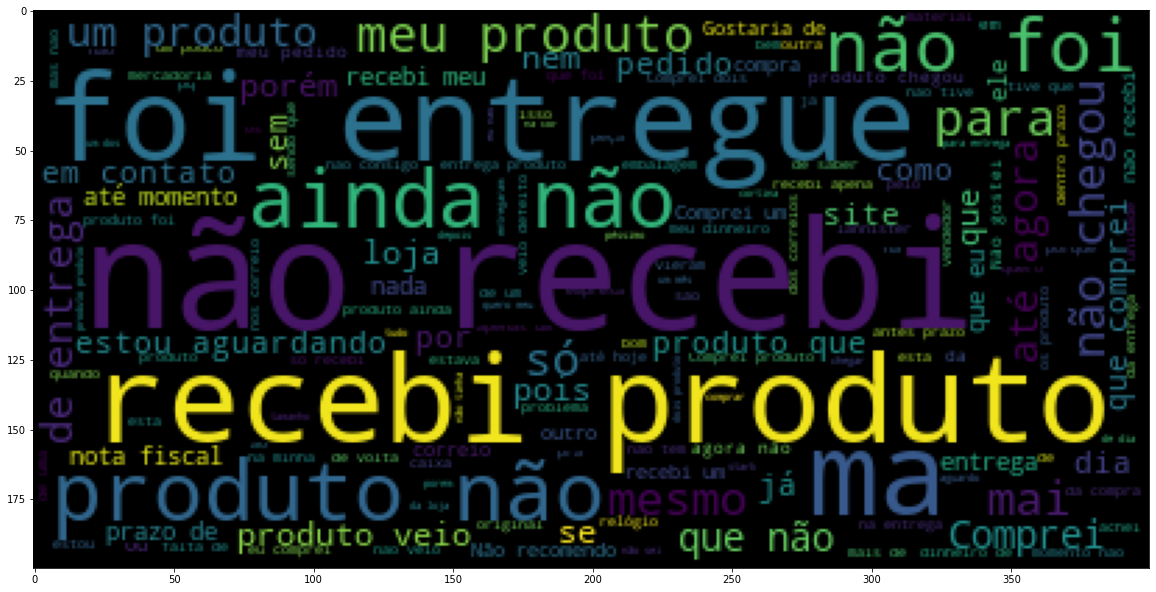

In [41]:
# Gerando a imagem
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(negative_sentence_as_one_string));

## Remoção de pontuação

Para criar o modelo preditivo de sentimento precisamos tratar os dados (da coluna reviews) e o tratamento neste caso consiste na remoção de pontuação e das chamadas "stop words". Inicialmente iremos tratar a pontuação para, na próxima seção, tratar as stop words.

In [42]:
# Importando a bibliotecas
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Podemos fazer um teste com um review para termos certeza que o código servirá para nosso propósito.

In [43]:
# Selecionando um review qualquer do dataframe
test = reviews['review_comment_message'].iloc[200]
test

'A entrega foi realizado muito antes do previsto. \r\nBom produto...estou satisfeita'

In [44]:
test_punct = [letra for letra in test if letra not in string.punctuation]
print(test_punct)

['A', ' ', 'e', 'n', 't', 'r', 'e', 'g', 'a', ' ', 'f', 'o', 'i', ' ', 'r', 'e', 'a', 'l', 'i', 'z', 'a', 'd', 'o', ' ', 'm', 'u', 'i', 't', 'o', ' ', 'a', 'n', 't', 'e', 's', ' ', 'd', 'o', ' ', 'p', 'r', 'e', 'v', 'i', 's', 't', 'o', ' ', '\r', '\n', 'B', 'o', 'm', ' ', 'p', 'r', 'o', 'd', 'u', 't', 'o', 'e', 's', 't', 'o', 'u', ' ', 's', 'a', 't', 'i', 's', 'f', 'e', 'i', 't', 'a']


Note que removemos a pontuação do review original. Agora, podemos juntá-lo novamente em uma frase sem tais pontuações.

In [45]:
# Juntando novamente a frase
test_punct = ''.join(test_punct)
print(test_punct)

A entrega foi realizado muito antes do previsto 
Bom produtoestou satisfeita


## Remoção de stop words

Agora iremos remover as stop words, ou seja, aquelas palavras que não contruibuem para o significado positivou ou negativo dos reviews.

In [46]:
# Importando a biblioteca
import nltk

In [47]:
# Fazendo download de alguns pacotes
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Como os textos estão em português, precisamos baixar as stop words no mesmo idioma e para isso importaremos uma biblioteca específica do pacote ***nltk***.

In [48]:
# Importando bibliotecas
from nltk.corpus import stopwords

# Stop words em português
print(stopwords.words('portuguese'))


['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [49]:
# Verificando a quantidade de stop words
len(stopwords.words('portuguese'))

204

Podemos agora testar a remoção de stop words para o review de teste que criamos acima.

In [51]:
# Removendo stopwords do review de teste
test_punct = [word for word in test_punct.split() if word.lower() not in stopwords.words('portuguese')]

In [52]:
# Verificando o resultado
test_punct

['entrega',
 'realizado',
 'antes',
 'previsto',
 'Bom',
 'produtoestou',
 'satisfeita']